# Mapping migration

Introduction to vector data operations

## STEP 0: Set up

To get started on this notebook, you’ll need to restore any variables
from previous notebooks to your workspace. To save time and memory, make
sure to specify which variables you want to load.

In [3]:
%store -r

In [4]:
ecoregions_gdf

,SHAPE_AREA,geometry,ECO_NAME
ecoregion,,,
0,0.038948,"MULTIPOLYGON (((158.7141 -69.60657, 158.71264 ...",Adelie Land tundra
1,0.170599,"MULTIPOLYGON (((147.28819 -2.57589, 147.2715 -...",Admiralty Islands lowland rain forests
2,13.844952,"MULTIPOLYGON (((26.88659 35.32161, 26.88297 35...",Aegean and Western Turkey sclerophyllous and m...
3,1.355536,"MULTIPOLYGON (((65.48655 34.71401, 65.52872 34...",Afghan Mountains semi-desert
4,8.196573,"MULTIPOLYGON (((-160.26404 58.64097, -160.2673...",Ahklun and Kilbuck Upland Tundra
...,...,...,...
842,9.422097,"MULTIPOLYGON (((117.33111 -7.53306, 117.30525 ...",Sulawesi lowland rain forests
843,5.010930,"MULTIPOLYGON (((36.7375 -3.13, 36.7375 -3.1316...",East African montane forests
844,0.890325,"MULTIPOLYGON (((36.38 -8.96583, 36.38 -8.96667...",Eastern Arc forests


:::

### Identify the ecoregion for each observation

You can combine the ecoregions and the observations **spatially** using
a method called `.sjoin()`, which stands for spatial join.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-read"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Read More</div></div><div class="callout-body-container callout-body"><p>Check out the <a
href="https://geopandas.org/en/stable/docs/user_guide/mergingdata.html#spatial-joins"><code>geopandas</code>
documentation on spatial joins</a> to help you figure this one out. You
can also ask your favorite LLM (Large-Language Model, like ChatGPT)</p></div></div>

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Perform a spatial join</div></div><div class="callout-body-container callout-body"><p>Identify the correct values for the <code>how=</code> and
<code>predicate=</code> parameters of the spatial join.</p></div></div>

In [5]:
gbif_ecoregion_gdf = (
    ecoregions_gdf
    # Match the CRS of the GBIF data and the ecoregions
    .to_crs(gbif_gdf.crs)
    # Find ecoregion for each observation
    .sjoin(
        gbif_gdf,
        how='inner', 
        predicate='intersects')
    # Select the required columns
    #[['ecoregion', 'SHAPE_AREA', 'month']]
)
gbif_ecoregion_gdf

,SHAPE_AREA,geometry,ECO_NAME,gbifID,month
ecoregion,,,,,
12,17.133639,"MULTIPOLYGON (((-119.53979 55.81661, -119.5443...",Alberta-British Columbia foothills forests,4743927038,5
12,17.133639,"MULTIPOLYGON (((-119.53979 55.81661, -119.5443...",Alberta-British Columbia foothills forests,4621947377,5
12,17.133639,"MULTIPOLYGON (((-119.53979 55.81661, -119.5443...",Alberta-British Columbia foothills forests,4761090115,6
12,17.133639,"MULTIPOLYGON (((-119.53979 55.81661, -119.5443...",Alberta-British Columbia foothills forests,5536938630,7
12,17.133639,"MULTIPOLYGON (((-119.53979 55.81661, -119.5443...",Alberta-British Columbia foothills forests,4630693711,6
...,...,...,...,...,...
839,5.586107,"MULTIPOLYGON (((-9.09602 52.60926, -9.07859 52...",North Atlantic moist mixed forests,4746476478,9
839,5.586107,"MULTIPOLYGON (((-9.09602 52.60926, -9.07859 52...",North Atlantic moist mixed forests,4775896521,10
839,5.586107,"MULTIPOLYGON (((-9.09602 52.60926, -9.07859 52...",North Atlantic moist mixed forests,4636615410,9


### Count the observations in each ecoregion each month

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Group observations by ecoregion</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Replace <code>columns_to_group_by</code> with a list of columns.
Keep in mind that you will end up with one row for each group – you want
to count the observations in each ecoregion by month.</li>
<li>Select only month/ecosystem combinations that have more than one
occurrence recorded, since a single occurrence could be an error.</li>
<li>Use the <code>.groupby()</code> and <code>.mean()</code> methods to
compute the mean occurrences by ecoregion and by month.</li>
<li>Run the code – it will normalize the number of occurrences by month
and ecoretion.</li>
</ol></div></div>

In [34]:
# Group observations by ecoregion
occurrence_df = (
    gbif_ecoregion_gdf
    # Select only necessary columns
    #[['ecoregion', 'SHAPE_AREA', 'month']]
    # For each ecoregion, for each month...
    .groupby(['month', 'ecoregion'])
    # ...count the number of occurrences
    .agg(occurrences=('ECO_NAME', 'count'),
         area=('SHAPE_AREA', 'first'))
)

# Get rid of rare observations (possible misidentification?)
occurrence_df = occurrence_df[occurrence_df.occurrences>5]
occurrence_df

occurrences        area
month ecoregion                         
1     152                 17  161.003728
2     152                 17  161.003728
3     348                  8   21.820507
      422                  7   34.040262
4     32                 103   16.637804
...                      ...         ...
10    783                  6    8.340400
      804                  6    5.968650
      839                  9    5.586107
11    152                 25  161.003728
12    152                 14  161.003728

[237 rows x 2 columns]

In [35]:
#Create Area-Normalized column
occurrence_df['NormAreaOccurrences'] = (occurrence_df.occurrences / 
                                        occurrence_df.area)
occurrence_df = occurrence_df[['NormAreaOccurrences', 'occurrences', 'area']]
occurrence_df

NormAreaOccurrences  occurrences        area
month ecoregion                                              
1     152                   0.105588           17  161.003728
2     152                   0.105588           17  161.003728
3     348                   0.366628            8   21.820507
      422                   0.205639            7   34.040262
4     32                    6.190721          103   16.637804
...                              ...          ...         ...
10    783                   0.719390            6    8.340400
      804                   1.005253            6    5.968650
      839                   1.611140            9    5.586107
11    152                   0.155276           25  161.003728
12    152                   0.086955           14  161.003728

[237 rows x 3 columns]

In [36]:
# Take the mean by ecoregion
mean_occurrences_by_ecoregion = (
    occurrence_df
    [['occurrences']]
    .groupby('ecoregion')
    .mean()
)
mean_occurrences_by_ecoregion

,occurrences
ecoregion,
16,1739.200000
32,952.857143
33,248.000000
34,360.200000
49,198.571429
...,...
804,6.333333
827,9.000000
832,140.000000


In [37]:
# Take the mean by month
mean_occurrences_by_month = (
    occurrence_df
    [['occurrences']]
    .groupby('month')
    .mean()
)
mean_occurrences_by_month

,occurrences
month,
1,17.000000
2,17.000000
3,7.500000
4,243.761905
5,1364.679245
6,1206.486486
7,632.714286
8,212.724138
9,367.214286


### Normalize the observations

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Normalize</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Divide occurrences by the mean occurrences by month AND the mean
occurrences by ecoregion</li>
</ol></div></div>

In [38]:
occurrence_df

NormAreaOccurrences  occurrences        area
month ecoregion                                              
1     152                   0.105588           17  161.003728
2     152                   0.105588           17  161.003728
3     348                   0.366628            8   21.820507
      422                   0.205639            7   34.040262
4     32                    6.190721          103   16.637804
...                              ...          ...         ...
10    783                   0.719390            6    8.340400
      804                   1.005253            6    5.968650
      839                   1.611140            9    5.586107
11    152                   0.155276           25  161.003728
12    152                   0.086955           14  161.003728

[237 rows x 3 columns]

In [39]:
# Normalize by space and time for sampling effort
occurrence_df['norm_occurrences'] = (
    occurrence_df.occurrences / occurrence_df.area)

occurrence_df

/tmp/ipykernel_1020/2234093318.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  occurrence_df['norm_occurrences'] = (


NormAreaOccurrences  occurrences        area  \
month ecoregion                                                 
1     152                   0.105588           17  161.003728   
2     152                   0.105588           17  161.003728   
3     348                   0.366628            8   21.820507   
      422                   0.205639            7   34.040262   
4     32                    6.190721          103   16.637804   
...                              ...          ...         ...   
10    783                   0.719390            6    8.340400   
      804                   1.005253            6    5.968650   
      839                   1.611140            9    5.586107   
11    152                   0.155276           25  161.003728   
12    152                   0.086955           14  161.003728   

                 norm_occurrences  
month ecoregion                    
1     152                0.105588  
2     152                0.105588  
3     348                0.366628  
      422                0.205639  
4     32                 6.190721  
...                           ...  
10    783                0.719390  
      804                1.005253  
      839                1.611140  
11    152                0.155276  
12    152                0.086955  

[237 rows x 4 columns]

In [40]:
# Normalize by regional variation and time for sampling effort
normoccurrences_df = (
    occurrence_df
    / occurrence_df
    / mean_occurrences_by_ecoregion
    / mean_occurrences_by_month
)
#Add non-normalized occurrences
normoccurrences_df['total_occurrences'] = occurrence_df['occurrences'] 

#Select normalized and absolute occurences columns
normoccurrences_df = normoccurrences_df[['NormAreaOccurrences', 'total_occurrences']]

normoccurrences_df

NormAreaOccurrences  total_occurrences
month ecoregion                                        
1     152                        NaN                 17
2     152                        NaN                 17
3     348                        NaN                  8
      422                        NaN                  7
4     32                         NaN                103
...                              ...                ...
10    783                        NaN                  6
      804                        NaN                  6
      839                        NaN                  9
11    152                        NaN                 25
12    152                        NaN                 14

[237 rows x 2 columns]

/tmp/ipykernel_1020/2621817529.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  occurrence_df['norm_occurrences2'] = (


<Axes: ylabel='Frequency'>

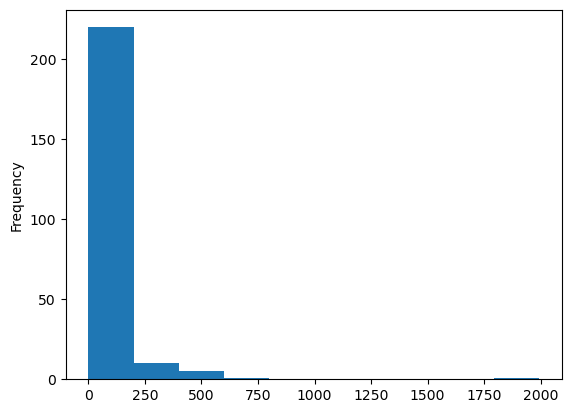

In [41]:
# Normalize by space and time for sampling effort
occurrence_df['norm_occurrences2'] = (
    occurrence_df.norm_occurrences
    / mean_occurrences_by_ecoregion.occurrences
    / mean_occurrences_by_month.occurrences
)
occurrence_df.norm_occurrences.plot.hist()

In [42]:
occurrence_df

NormAreaOccurrences  occurrences        area  \
month ecoregion                                                 
1     152                   0.105588           17  161.003728   
2     152                   0.105588           17  161.003728   
3     348                   0.366628            8   21.820507   
      422                   0.205639            7   34.040262   
4     32                    6.190721          103   16.637804   
...                              ...          ...         ...   
10    783                   0.719390            6    8.340400   
      804                   1.005253            6    5.968650   
      839                   1.611140            9    5.586107   
11    152                   0.155276           25  161.003728   
12    152                   0.086955           14  161.003728   

                 norm_occurrences  norm_occurrences2  
month ecoregion                                       
1     152                0.105588           0.000340  
2     152                0.105588           0.000340  
3     348                0.366628           0.006110  
      422                0.205639           0.003917  
4     32                 6.190721           0.000027  
...                           ...                ...  
10    783                0.719390           0.000014  
      804                1.005253           0.003398  
      839                1.611140           0.001864  
11    152                0.155276           0.000340  
12    152                0.086955           0.000340  

[237 rows x 5 columns]

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Make sure to store the new version of your <code>DataFrame</code> for
other notebooks!</p>
<div id="f13606e9" class="cell" data-execution_count="9">
<div class="sourceCode" id="cb1"><pre
class="sourceCode python cell-code"><code class="sourceCode python"><span id="cb1-1"><a href="#cb1-1" aria-hidden="true" tabindex="-1"></a><span class="op">%</span>store occurrence_df</span></code></pre></div>
</div></div></div>

# STEP -1: Wrap up

Don’t forget to store your variables so you can use them in other
notebooks! Replace `var1` and `var2` with the variable you want to save,
separated by spaces.

In [43]:
%store occurrence_df

Stored 'occurrence_df' (DataFrame)


Finally, be sure to `Restart` and `Run all` to make sure your notebook
works all the way through!